Our baseline will be classificator + parapharser

In [1]:
import pandas as pd
data = pd.read_csv('../data/interim/words.csv', index_col=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24645 entries, 0 to 24644
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   word    24640 non-null  object
 1   target  24645 non-null  object
dtypes: object(2)
memory usage: 577.6+ KB


In [2]:
print(f'Number of words in dataset: {len(data)}')
print(f'Unique words in dataset: {len(data["word"].unique())}')
print(f'Nulls: {data["word"].isna().sum()}')

Number of words in dataset: 24645
Unique words in dataset: 12670
Nulls: 5


Drop rows without words and duplicate rows

In [3]:
data = data.dropna(subset=['word'])
data = data.drop_duplicates()

Same Words can be both negative and positive meanings based on context, which is why we categorize them as "Negative" to prevent False Positive identifications. This approach can enhance precision scores but may result in a decrease in recall, as it could lead to more instances of False Negatives. For our specific task, this is not particularly crucial, as we have the option to substitute positive words with alternative positive terms.

![Alt text](https://www.researchgate.net/publication/336402347/figure/fig3/AS:812472659349505@1570719985505/Calculation-of-Precision-Recall-and-Accuracy-in-the-confusion-matrix.ppm "a title")


In [4]:
data.loc[data['word'].duplicated(keep=False), 'target'] = 'Negative'
data = data.drop_duplicates()

In [5]:
print(f'Number of words in dataset: {len(data)}')
print(f'Unique words in dataset: {len(data["word"].unique())}')
print(f'Nulls: {data["word"].isna().sum()}')

Number of words in dataset: 12669
Unique words in dataset: 12669
Nulls: 0


Let's see the distribution of target value

<BarContainer object of 2 artists>

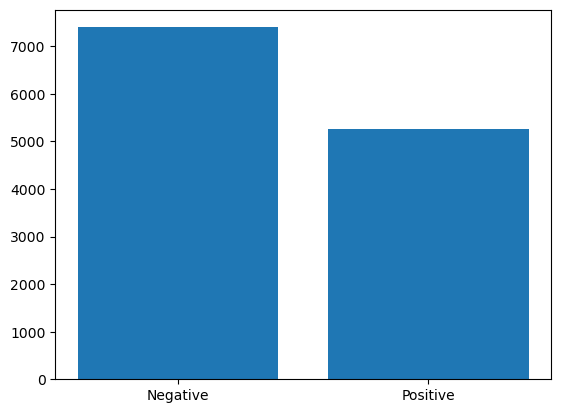

In [6]:
import matplotlib.pyplot as plt
target_counts = data['target'].value_counts()
target_counts.sort_index()
plt.bar(target_counts.index, target_counts.values)

In [7]:
from sklearn.model_selection import train_test_split
data['target'] = data['target'].replace({'Positive': 0, 'Negative': 1})
X_train, y_train = data['word'], data['target']

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import string
from nltk.tokenize import word_tokenize

def Preprocessor(text):
    
    if isinstance(text, list):
        text = pd.Series(text)

    if isinstance(text, pd.core.series.Series):
        return text.str.lower().str.strip()
    elif isinstance(text, str):
        text = text.translate(str.maketrans('', '', string.punctuation))
        text = text.lower()
        tokenized = word_tokenize(text)
        return tokenized


classificator = Pipeline([
    ('preprocessor', FunctionTransformer(func=Preprocessor)),
    ('vectorizer', CountVectorizer()),
    ('classifier', LogisticRegression())
])

classificator.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 FunctionTransformer(func=<function Preprocessor at 0x000001AA35928A60>)),
                ('vectorizer', CountVectorizer()),
                ('classifier', LogisticRegression())])

In [9]:
from nltk.wsd import lesk
import nltk
from nltk.corpus import stopwords
import numpy as np

nltk.download('punkt')
nltk.download('stopwords')


def paraphraser(sentence):
    stop_words = set(stopwords.words('english'))

    def get_synonym_by_context(word, context_sentence):
        # Disambiguate the word in the context sentence
        sense = lesk(context_sentence, word)

        # Find synonyms for the disambiguated sense
        synonyms = []
        if sense:
            for lemma in sense.lemmas():
                synonyms.append(lemma.name().replace('_', ' '))

        # Remove duplicates and display the closest synonym
        synonyms = list(set(synonyms))
        if len(synonyms) == 0:
            synonyms.append(word)
        #rearrange synonyms by they toxicity
        synonyms = sorted([(synonym, classificator.predict_proba(synonym)[0, 1]) for synonym in synonyms], key= lambda x: x[1])
        return synonyms[0][0]

    tokenized = Preprocessor(sentence)
    predictions = classificator.predict(tokenized)
    mask = np.array([0 if word in stop_words else 1 for word in tokenized])
    predictions = predictions * mask
    assert len(predictions) == len(tokenized)
    paraphrased = [get_synonym_by_context(word, sentence) if predictions[i] == 1 else word for i, word in enumerate(tokenized)]
    return ' '.join(paraphrased)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hir0\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hir0\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
detox_data = pd.read_csv('../data/interim/test_filtered.csv')

In [11]:
X, y_true = detox_data['reference'].values, detox_data['translation'].values

print(X[1])
print(f'Pred: {paraphraser(X[1])}\nTrue: {y_true[1]}')


i think any one of any party who hides from their constituents is a complete coward and a disgrace .
Pred: i think any one of any party who cover from their constituent is a complete coward and a shame
True: i think any one of any party who hides from their constituents is a complete naive


In [12]:
# predictions_baseline = pd.DataFrame({'Predictions': [paraphraser(sentence) for sentence in X]})
# predictions_baseline.to_csv('../data/interim/baseline_predictions.csv')

In [13]:
predictions_baseline = pd.read_csv('../data/interim/baseline_predictions.csv', index_col=0)
predictions_baseline = list(predictions_baseline['Predictions'].values)
predictions_baseline

['guanine what the love',
 'i think any one of any party who hide from their constituent is a complete coward and a disgrace',
 'we can have sex on the beach',
 "Sir Richrd Steele make up one's mind his only hope pose in playing dead",
 'heil die before they obtain him to a sawbones',
 'no wonder he visit it boy of a cunt eddie thought',
 'you think if you can obtain me in a car alone i habit be able to resist having sex with you',
 'yeah but He our kitty-cat',
 'youve become silly tail of what once you were',
 'where are my witness goddamn it',
 'did i not exterminate you once already',
 'there nothing wrong with you take out you saw wood too much',
 'to see him hang like Mussolini in Italian Republic or humble in a war trial would be more than they could hold',
 'leash him and hogtie him Patrick Henry',
 'i try to put option my coffeehouse yardbird leche down and it slop all over my ass',
 'Prairie State dotty daughter to whom he could never say no the flashingglanced tomboy fierce a

In [14]:
import sys
sys.path.insert(0, '../src/metric')
from metric import calculate_metric

calculate_metric(y_true, predictions_baseline)

running on cuda
Calculating style of predictions


Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 2070/2070 [01:20<00:00, 25.61it/s]
c:\Users\hir0\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower o

Calculating BLEU similarity
Calculating similarity by Wieting subword-embedding SIM model


100%|██████████| 2070/2070 [00:12<00:00, 166.05it/s]


Calculating CoLA acceptability stats


100%|██████████| 2070/2070 [03:53<00:00,  8.86it/s]

| ACC | SIM |  FL  |   J   | BLEU |

| --- | --- | ---- |  ---  | ---- |

|0.5989|0.5287|0.9021|0.2785|0.3897|



(0.5989216781949437,
 0.5287495034009352,
 0.9020901924064397,
 0.27845451200227356,
 0.38973602651116124)